In [1]:
# clone the repository to get the data

!git clone https://github.com/jx3yang/Dog-Breed-Classifier

Cloning into 'Dog-Breed-Classifier'...
remote: Enumerating objects: 10467, done.
remote: Counting objects: 100% (10467/10467), done.
remote: Compressing objects: 100% (10462/10462), done.
remote: Total 10467 (delta 2), reused 10464 (delta 2), pack-reused 0
Receiving objects: 100% (10467/10467), 343.33 MiB | 41.38 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob

from tensorflow.keras import layers

In [3]:
# data directories

train_path = f'{os.getcwd()}/Dog-Breed-Classifier/data/train'
test_path = f'{os.getcwd()}/Dog-Breed-Classifier/data/test'

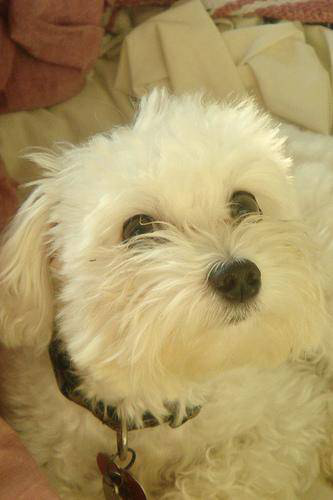

In [4]:
# image example

maltese = glob(f'{train_path}/maltese_dog/*')[1]
Image.open(maltese)

In [5]:
# set a few parameters

SEED = 42
BATCH_SIZE = 32
TARGET_HEIGHT = 150
TARGET_WIDTH = 150

In [6]:
from tensorflow.keras import preprocessing

# form the training and validation datasets

train_ds = preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=(TARGET_HEIGHT, TARGET_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=(TARGET_HEIGHT, TARGET_WIDTH),
    batch_size=BATCH_SIZE
)

Found 914 files belonging to 10 classes.
Using 732 files for training.
Found 914 files belonging to 10 classes.
Using 182 files for validation.


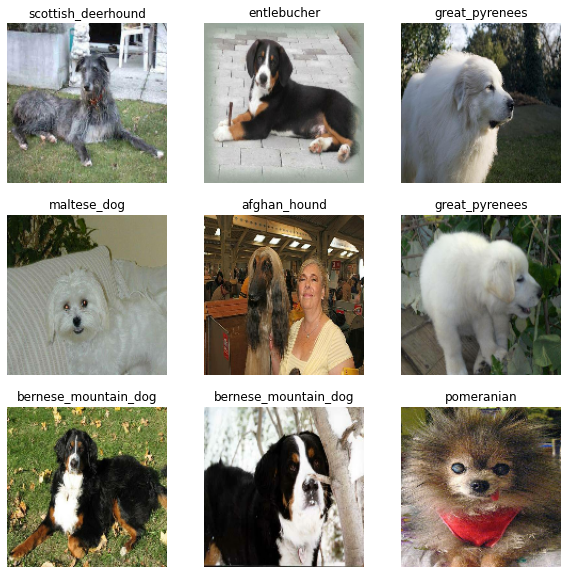

In [8]:
# explore some of the data of the different breeds

plt.figure(figsize=(10, 10))
for imgs, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis('off')

In [9]:
# set the buffer

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# we will need a few layers to augment the data, which helps avoiding overfitting

import tensorflow.keras.layers.experimental.preprocessing as exp_preprocessing

norm_layer = exp_preprocessing.Rescaling(
    1./255, input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))
flip_layer = exp_preprocessing.RandomFlip(
    'horizontal', input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))
rotation_layer = exp_preprocessing.RandomRotation(0.1)
zoom_layer = exp_preprocessing.RandomZoom(0.1)

augment_layer = lambda in_layer: zoom_layer(rotation_layer(flip_layer(norm_layer(in_layer))))

In [14]:
# use inception V3 as the base model, add the layers defined previously
# before inputting to inception V3, then add a few layers after its output layer
# as the classification head

num_classes = 10

inception_V3 = tf.keras.applications.InceptionV3(
  weights="imagenet", include_top=False, input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3)
)

inception_V3.trainable = False

inputs = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))

outputs = augment_layer(inputs)
outputs = inception_V3(outputs)
outputs = layers.GlobalAveragePooling2D()(outputs)
outputs = layers.Dropout(0.2)(outputs)
outputs = layers.Dense(64, activation='relu')(outputs)
outputs = layers.Dense(num_classes, activation="softmax")(outputs)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(1e-4)

model.compile(
  optimizer=opt,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"]
)

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)             

In [15]:
# training

epochs = 200

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/200
23/23 [==============================] - 2s 92ms/step - loss: 2.2841 - accuracy: 0.1585 - val_loss: 2.1464 - val_accuracy: 0.3462
Epoch 2/200
23/23 [==============================] - 1s 43ms/step - loss: 2.1324 - accuracy: 0.3402 - val_loss: 2.0382 - val_accuracy: 0.4286
Epoch 3/200
23/23 [==============================] - 1s 43ms/step - loss: 2.0686 - accuracy: 0.3852 - val_loss: 2.0203 - val_accuracy: 0.4341
Epoch 4/200
23/23 [==============================] - 1s 43ms/step - loss: 2.0313 - accuracy: 0.4276 - val_loss: 1.9455 - val_accuracy: 0.5055
Epoch 5/200
23/23 [==============================] - 1s 43ms/step - loss: 1.9724 - accuracy: 0.4986 - val_loss: 1.9236 - val_accuracy: 0.5440
Epoch 6/200
23/23 [==============================] - 1s 43ms/step - loss: 1.9374 - accuracy: 0.5301 - val_loss: 1.9153 - val_accuracy: 0.5440
Epoch 7/200
23/23 [==============================] - 1s 44ms/step - loss: 1.9392 - accuracy: 0.5328 - val_loss: 1.9009 - val_accuracy: 0.5659
Epoch 

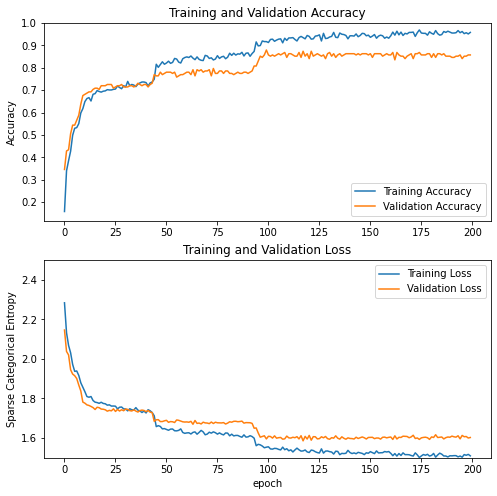

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Entropy')
plt.ylim([1.5,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [23]:
!mkdir saved_model

model.save('saved_model/model')
model.save('saved_model/model.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/model/assets


In [24]:
loaded_model = tf.keras.models.load_model('saved_model/model.h5')

In [25]:
# check accuracy on test dataset

test_ds = preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(TARGET_HEIGHT, TARGET_WIDTH),
    batch_size=BATCH_SIZE
)

Found 227 files belonging to 10 classes.


In [26]:
test_ds = test_ds.prefetch(AUTOTUNE)

In [27]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 79ms/step - loss: 1.6080 - accuracy: 0.8590


[1.6080178022384644, 0.8590308427810669]